## Predicting Airline Delays<br>

Notebook: Data Preparation Notebook
  
Team: Jimmy Nguyen, Maha Jayapal, Roberto Cancel<br>

In [1]:
!pip install --upgrade numpy #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
!pip install --upgrade pandas #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)

import boto3 # AWS SDK for Python
import io # for encoding issues with raw data sets
from io import StringIO # converting dataframe to csv and uploading to s3 bucket /tranformed folder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# INGEST Merged DATA

s3_client = boto3.client("s3")

BUCKET='ads-508-airline'
KEY='merged/Dec_modeling.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
dec_merged = pd.read_csv(response.get("Body"))
dec_merged.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,...,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,...,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,...,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,...,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,...,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,...,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84


In [3]:
dec_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        558026 non-null  int64  
 1   DAY_OF_WEEK         558026 non-null  int64  
 2   OP_UNIQUE_CARRIER   558026 non-null  object 
 3   TAIL_NUM            558026 non-null  object 
 4   ORIGIN_AIRPORT_ID   558026 non-null  int64  
 5   ORIGIN              558026 non-null  object 
 6   DEST                558026 non-null  object 
 7   DEP_DEL15           558026 non-null  float64
 8   DEP_TIME_BLK        558026 non-null  object 
 9   ARR_TIME_BLK        558026 non-null  object 
 10  CANCELLED           558026 non-null  float64
 11  CRS_ELAPSED_TIME    558026 non-null  float64
 12  DISTANCE            558026 non-null  float64
 13  DISTANCE_GROUP      558026 non-null  int64  
 14  AIRLINE_ID          558026 non-null  int64  
 15  CARRIER_NAME        558026 non-nul

In [4]:
dec_merged.shape

(558026, 25)

# Data Cleaning

All missing values were imputed or dropped, as described above. Since our data has been validated by the Bureau of Transportation Statistics and Climate Data Online, outliers were investigated by reviewing the summary statistics of our data set. 



In [5]:
dec_merged.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,DEP_DEL15,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
count,558026.000000,558026.000000,558026.000000,558026.000000,558026.0,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000,558026.000000
mean,15.830902,3.938745,12666.002996,0.208399,0.0,148.552937,843.568687,3.844704,19954.738880,6132.518447,7380.776432,9991.061352,3576.673642,0.116641,0.048059,0.121935,56.160668,8.137934
std,8.957760,2.085336,1514.187330,0.406164,0.0,74.475448,604.827406,2.372199,368.971181,3163.783165,5905.764240,6417.203879,3092.215270,0.352309,0.347030,0.806783,14.612596,4.014022
min,1.000000,1.000000,10140.000000,0.000000,0.0,34.000000,66.000000,1.000000,19393.000000,586.000000,0.000000,154.000000,34.000000,0.000000,0.000000,0.000000,8.000000,0.000000
25%,8.000000,2.000000,11292.000000,0.000000,0.0,94.000000,400.000000,2.000000,19790.000000,2444.000000,1407.000000,3592.000000,898.000000,0.000000,0.000000,0.000000,45.000000,4.920000
50%,16.000000,4.000000,12889.000000,0.000000,0.0,130.000000,680.000000,3.000000,19930.000000,7637.000000,8586.000000,15237.000000,2482.000000,0.000000,0.000000,0.000000,56.000000,7.610000
75%,23.000000,6.000000,13931.000000,0.000000,0.0,179.000000,1075.000000,5.000000,20314.000000,8989.000000,9668.000000,15502.000000,6122.000000,0.040000,0.000000,0.000000,67.000000,10.510000
max,31.000000,7.000000,15919.000000,1.000000,0.0,705.000000,5095.000000,11.000000,20436.000000,9293.000000,16888.000000,15809.000000,9677.000000,7.130000,13.300000,18.100000,87.000000,25.720000


Evaluation of min and max values indicate that outliers do not exist. Also, thanks to the preprocessing of our datasets before merging, duplicates and formatting issues were already resolved.


## 1. Feature Selection 

- We will disregard columns with IDs
- Also drop any redundant columns such as having only 1 distinct value 
- Since we have both the distance and distance group column, it is redundant or DEP_TIME_BLK vs. ARR_TIME_BLK

In [6]:
dec_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        558026 non-null  int64  
 1   DAY_OF_WEEK         558026 non-null  int64  
 2   OP_UNIQUE_CARRIER   558026 non-null  object 
 3   TAIL_NUM            558026 non-null  object 
 4   ORIGIN_AIRPORT_ID   558026 non-null  int64  
 5   ORIGIN              558026 non-null  object 
 6   DEST                558026 non-null  object 
 7   DEP_DEL15           558026 non-null  float64
 8   DEP_TIME_BLK        558026 non-null  object 
 9   ARR_TIME_BLK        558026 non-null  object 
 10  CANCELLED           558026 non-null  float64
 11  CRS_ELAPSED_TIME    558026 non-null  float64
 12  DISTANCE            558026 non-null  float64
 13  DISTANCE_GROUP      558026 non-null  int64  
 14  AIRLINE_ID          558026 non-null  int64  
 15  CARRIER_NAME        558026 non-nul

Of the 24 features remaining in our dataset, several were redundant upon inspection. ORIGIN_AIRPORT_ID is redundant with ORIGIN. ARR_TIME_BLK, which represents the arrival time block, is redundant with the combination of DEP_TIME_BLK and CRS_ELAPSED_TIME, or the schedule length of the flight, and DISTANCE_GROUP, or the distance of the flight. AIRLINE_ID is redundant with CARRIER_NAME. DISTANCE is redundant with the DISTANCE_GROUP binned feature. Since CRS_ELAPSED_TIME would be a function of the distance traveled, it was also dropped. OP_UNIQUE_CARRIER is redundant with CARRIER_NAME, which is also easier to interpret in subsequent sections, therefore OP_UNIQUE_CARRIER will be dropped. Since all cancelled flights were removed, the CANCELLED feature is irrelevant. This left 17 features in our dataset. Some features, such as CARRIER_NAME, ORIGIN, and DEST will not be used in modeling but are retained for later use.


In [7]:
dropped = ['TAIL_NUM','ORIGIN_AIRPORT_ID', 'ARR_TIME_BLK','CANCELLED','AIRLINE_ID','DISTANCE', 'CRS_ELAPSED_TIME', 'OP_UNIQUE_CARRIER']
dec_red = dec_merged.drop(dropped, axis=1)
dec_red.head()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8,7,STL,SAN,0.0,1100-1159,7,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
1,8,7,STL,SAT,0.0,1200-1259,4,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
2,8,7,STL,SAT,0.0,2100-2159,4,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
3,8,7,STL,SEA,0.0,0900-0959,7,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
4,8,7,STL,SFO,1.0,1800-1859,7,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84


In [8]:
dec_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        558026 non-null  int64  
 1   DAY_OF_WEEK         558026 non-null  int64  
 2   ORIGIN              558026 non-null  object 
 3   DEST                558026 non-null  object 
 4   DEP_DEL15           558026 non-null  float64
 5   DEP_TIME_BLK        558026 non-null  object 
 6   DISTANCE_GROUP      558026 non-null  int64  
 7   CARRIER_NAME        558026 non-null  object 
 8   PILOTS_COPILOTS     558026 non-null  int64  
 9   PASSENGER_HANDLING  558026 non-null  int64  
 10  PASS_GEN_SVC_ADMIN  558026 non-null  int64  
 11  MAINTENANCE         558026 non-null  int64  
 12  PRCP                558026 non-null  float64
 13  SNOW                558026 non-null  float64
 14  SNWD                558026 non-null  float64
 15  TMAX                558026 non-nul

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


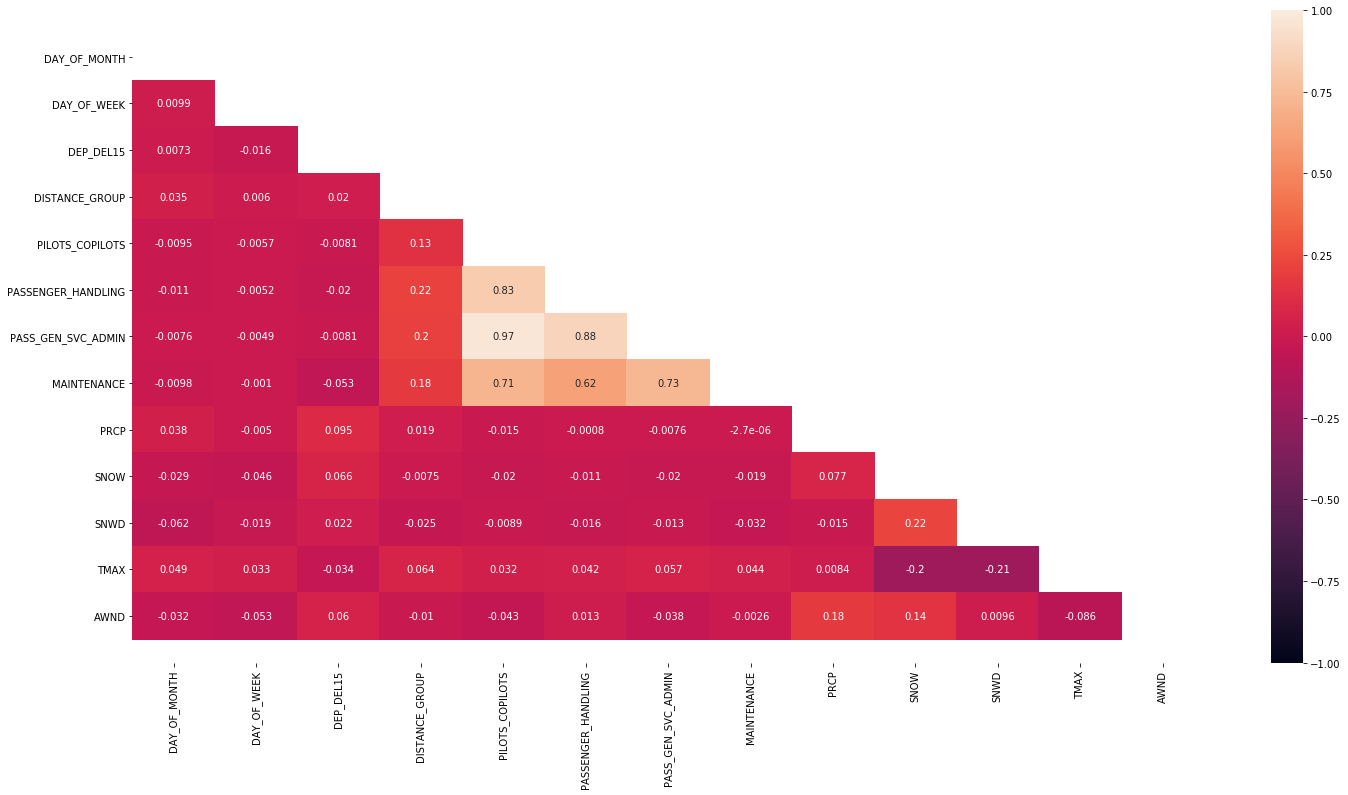

In [9]:
# Correlation Matrix for multicollinearity
plt.figure(figsize=(24, 12))
mask = np.triu(np.ones_like(dec_red.corr(), dtype=np.bool))
heatmap = sns.heatmap(dec_red.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

# Make the full heat map visible
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## 2. Feature Creation

Since the day of the month did not show an easily identifiable pattern for departure delays, a new feature WEEK_OF_MONTH was created. This feature consists of 4 full (7-day) weeks and 1 partial (3-day) week. WEEK_OF_MONTH distributions for departure delay were evaluated to determine the optimal feature to use.
    
    WEEK_OF_MONTH

      1-7 = Week 1 = 1  
      8-14 = Week 2 = 2  
      15-21 = Week 3 = 3  
      22-28 = week 4 = 4  
      29-31 = partial week 5 = 5  

While DEP_TIME_BLK showed- REDUCE CARDINALITY OF DEPARTURE TIME BLOCKS (PREVIOUSLY 19 levels with inconsistent bucket size to 4 bins)

      Redeye/Early Departure = 12:01 a.m. - 5:59 a.m  = 1
      Morning Departure = 6:00 a.m - 11:59 a.m.  = 2
      Daytime Departure = 12:00 p.m. - 5:59 p.m = 3
      Late Departure = 6:00 p.m. - 11:59 p.m. = 4



### Create WEEK_OF_MONTH

In [10]:
def month_weeks_range(x):
    if x <= 7:
        return 1
    elif x <= 14:
        return 2
    elif x <= 21:
        return 3
    elif x <= 28:
        return 4
    else:
        return 5

dec_red['WEEK_OF_MONTH'] = dec_red['DAY_OF_MONTH'].apply(lambda x: month_weeks_range(x))
dec_red['WEEK_OF_MONTH'].value_counts()

3    129144
1    128108
2    125664
4    122390
5     52720
Name: WEEK_OF_MONTH, dtype: int64

In [11]:
# Explore DAY OF MONTH with DEP_DEL15
Week = pd.crosstab(dec_red['WEEK_OF_MONTH'], dec_red['DEP_DEL15'])
Week['Total'] = Week.sum(axis=1)
Week.loc['Total'] = Week.sum()
Week['Percent_Delayed'] = ((Week.iloc[:,1])/((Week.iloc[:,0])+(Week.iloc[:,1])))
Week = Week.sort_values('Percent_Delayed')
Week

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
WEEK_OF_MONTH,,,,
2,102803,22861,125664,0.181922
Total,441734,116292,558026,0.208399
3,101636,27508,129144,0.213003
1,100715,27393,128108,0.213827
4,95691,26699,122390,0.218147
5,40889,11831,52720,0.224412


In [12]:
# Drop DAY_OF_MONTH in place of WEEK_OF_MONTH
dec_red.drop(columns=['DAY_OF_MONTH'], inplace = True)

### Transform DEP_TIME_BLK

In [13]:
dep_blk = {'0600-0659':2, '0700-0759':2, '0800-0859':2,
           '0900-0959':2,'1000-1059':2, '1100-1159':2,
           '1200-1259':3, '1300-1359':3, '1400-1459':3,
           '1500-1559':3, '1600-1659':3, '1700-1759':3,
           '1800-1859':4, '1900-1959':4,'2000-2059':4, 
           '2100-2159':4, '2200-2259':4, 
           '2200-2259':4, '2300-2359':4, '0001-0559':1}

dec_red['DEP_TIME_BLK'] = dec_red['DEP_TIME_BLK'].replace(dep_blk)
dec_red['DEP_TIME_BLK'].value_counts()

2    213792
3    197393
4    131938
1     14903
Name: DEP_TIME_BLK, dtype: int64

In [14]:
# Explore DEP_TIME_BLK with DEP_DEL15
DEP = pd.crosstab(dec_red['DEP_TIME_BLK'], dec_red['DEP_DEL15'])
DEP['Total'] = DEP.sum(axis=1)
DEP.loc['Total'] = DEP.sum()
DEP['Percent_Delayed'] = ((DEP.iloc[:,1])/((DEP.iloc[:,0])+(DEP.iloc[:,1])))
DEP = DEP.sort_values('Percent_Delayed')
DEP

DEP_DEL15,0.0,1.0,Total,Percent_Delayed
DEP_TIME_BLK,,,,
1,13563,1340,14903,0.089915
2,183722,30070,213792,0.140651
Total,441734,116292,558026,0.208399
3,150278,47115,197393,0.238686
4,94171,37767,131938,0.286248


## 3. Feature Transformation

Since the non-numeric features remaining in our dataset will not be ingested in the model, but used later to enhance findings, interpretations and recommendations, and we are using the XGBoost Classification algorithm for modeling purposes, further transformations are unnecessary. XGBoost is not sensitive to transformations or scaling of features in the same way that decision trees and random forest are not. By not scaling our features, we remove the need to scale subsequent data ingested by the model and facilitate easier interpretability of our model with real-world data.


In [15]:
# List remaining features and types
dec_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_WEEK         558026 non-null  int64  
 1   ORIGIN              558026 non-null  object 
 2   DEST                558026 non-null  object 
 3   DEP_DEL15           558026 non-null  float64
 4   DEP_TIME_BLK        558026 non-null  int64  
 5   DISTANCE_GROUP      558026 non-null  int64  
 6   CARRIER_NAME        558026 non-null  object 
 7   PILOTS_COPILOTS     558026 non-null  int64  
 8   PASSENGER_HANDLING  558026 non-null  int64  
 9   PASS_GEN_SVC_ADMIN  558026 non-null  int64  
 10  MAINTENANCE         558026 non-null  int64  
 11  PRCP                558026 non-null  float64
 12  SNOW                558026 non-null  float64
 13  SNWD                558026 non-null  float64
 14  TMAX                558026 non-null  float64
 15  AWND                558026 non-nul

## 4. Balance the data set

In [16]:
# Identify the imbalanced class
dec_red['DEP_DEL15'].value_counts()

0.0    441734
1.0    116292
Name: DEP_DEL15, dtype: int64

In [17]:
df_grouped_by =  dec_red.groupby(["DEP_DEL15"])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()))
df_balanced.reset_index(drop=True, inplace =True)
df_balanced

,DAY_OF_WEEK,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,2,ATL,DEN,0.0,4,5,Southwest Airlines Co.,8989,9668,15475,2482,0.00,0.0,0.0,56.0,11.86,5
1,6,MSP,FLL,0.0,2,6,Delta Air Lines Inc.,9293,15331,15809,6122,0.00,0.0,0.0,72.0,7.83,1
2,5,OGG,SFO,0.0,4,10,United Air Lines Inc.,7637,16888,15237,4991,0.39,0.0,0.0,81.0,7.38,1
3,5,IAD,SEA,0.0,3,10,Delta Air Lines Inc.,9293,15331,15809,6122,0.25,0.0,0.0,38.0,5.82,2
4,3,SEA,BOI,0.0,3,2,Alaska Airlines Inc.,2893,1062,5737,898,0.54,0.0,0.0,49.0,8.05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232579,2,SEA,BUR,1.0,2,4,Alaska Airlines Inc.,2893,1062,5737,898,0.00,0.0,0.0,40.0,4.70,4
232580,1,PHX,TUS,1.0,4,1,Mesa Airlines Inc.,1312,0,1205,34,0.00,0.0,0.0,62.0,6.49,3
232581,4,SAN,SEA,1.0,3,5,Delta Air Lines Inc.,9293,15331,15809,6122,0.00,0.0,0.0,69.0,2.91,1
232582,6,TPA,ATL,1.0,3,2,Delta Air Lines Inc.,9293,15331,15809,6122,0.32,0.0,0.0,80.0,10.07,4


In [18]:
# Confirm the majority class was undersampled
df_balanced['DEP_DEL15'].value_counts()

0.0    116292
1.0    116292
Name: DEP_DEL15, dtype: int64

## 5. Split the data set

In [19]:
# partition model used features
model = df_balanced.drop(['ORIGIN','DEST', 'CARRIER_NAME'], axis = 1)

# Move DEP_DEL15 to first position for modeling
Dep = model['DEP_DEL15']
model.drop(labels=['DEP_DEL15'], axis=1,inplace = True)
model.insert(0, 'DEP_DEL15', Dep)
model

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,0.0,2,4,5,8989,9668,15475,2482,0.00,0.0,0.0,56.0,11.86,5
1,0.0,6,2,6,9293,15331,15809,6122,0.00,0.0,0.0,72.0,7.83,1
2,0.0,5,4,10,7637,16888,15237,4991,0.39,0.0,0.0,81.0,7.38,1
3,0.0,5,3,10,9293,15331,15809,6122,0.25,0.0,0.0,38.0,5.82,2
4,0.0,3,3,2,2893,1062,5737,898,0.54,0.0,0.0,49.0,8.05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232579,1.0,2,2,4,2893,1062,5737,898,0.00,0.0,0.0,40.0,4.70,4
232580,1.0,1,4,1,1312,0,1205,34,0.00,0.0,0.0,62.0,6.49,3
232581,1.0,4,3,5,9293,15331,15809,6122,0.00,0.0,0.0,69.0,2.91,1
232582,1.0,6,3,2,9293,15331,15809,6122,0.32,0.0,0.0,80.0,10.07,4


In [20]:
# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(model, test_size=0.10, stratify=model['DEP_DEL15'])

# Split holdout to 50% validation and 50% test
df_val, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['DEP_DEL15'])

add code to upload to bucket

In [21]:
df_train.shape

(209325, 14)

In [22]:
df_val.shape

(11629, 14)

In [23]:
df_test.shape

(11630, 14)

In [30]:
# Save train data set for modeling to model_data folder in bucket
csv_buffer=StringIO()
df_train.to_csv(csv_buffer, index=False)

BUCKET_NAME = 'ads-508-airline'
FileName= 'model_data/df_train.csv'

s3csv = boto3.client('s3')

response=s3csv.put_object(Body=csv_buffer.getvalue(),
                           Bucket=BUCKET_NAME,
                           Key=FileName)

In [31]:
# Save validation data set for modeling to model_data folder in bucket
csv_buffer=StringIO()
df_val.to_csv(csv_buffer, index=False)

BUCKET_NAME = 'ads-508-airline'
FileName= 'model_data/df_val.csv'

s3csv = boto3.client('s3')

response=s3csv.put_object(Body=csv_buffer.getvalue(),
                           Bucket=BUCKET_NAME,
                           Key=FileName)

In [32]:
# Save test data set for modeling to model_data folder in bucket
csv_buffer=StringIO()
df_test.to_csv(csv_buffer, index=False)

BUCKET_NAME = 'ads-508-airline'
FileName= 'model_data/df_test.csv'

s3csv = boto3.client('s3')

response=s3csv.put_object(Body=csv_buffer.getvalue(),
                           Bucket=BUCKET_NAME,
                           Key=FileName)